# Setup

In [1]:
pip install -r ../requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Add directory above current directory to path
import sys

sys.path.insert(0, '..')

In [ ]:
sys.path.remove('/home/es/es_es/es_kamait02/.local/lib/python3.9/site-packages')
sys.path.append('/home/es/es_es/es_kamait02/.local/lib/python3.9/site-packages')

In [3]:
import pandas as pd
import numpy as np
import os
import gzip
import glob
import json
from tqdm import tqdm

ModuleNotFoundError: No module named 'pandas.util'

In [ ]:
path = "../datasets/flickr30k_images"

# Downloading data

The Flickr30k dataset is available at https://www.kaggle.com/datasets/hsankesara/flickr-image-dataset

To automatically download the Flickr30k data using Kaggle API, ensure you have API credentials set up.

For further information see https://github.com/Kaggle/kaggle-api

In [6]:
!kaggle datasets download -d hsankesara/flickr-image-dataset -p ../datasets --unzip

/bin/bash: /anaconda/envs/jupyter_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)
100%|█████████████████████████████████████▉| 8.16G/8.16G [03:48<00:00, 41.2MB/s]
100%|██████████████████████████████████████| 8.16G/8.16G [03:48<00:00, 38.3MB/s]


In [7]:
# removing duplicate images folder

!rm -rf {os.path.join(path, "flickr30k_images/flickr30k_images")}

/bin/bash: /anaconda/envs/jupyter_env/lib/libtinfo.so.6: no version information available (required by /bin/bash)


# Load data

In [6]:
data = pd.read_csv(os.path.join(path, "results.csv"), sep="|", skipinitialspace=True)
data

,image_name,comment_number,comment
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,1,"Two young , White males are outside near many ..."
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .
4,1000092795.jpg,4,Two friends enjoy time spent together .
...,...,...,...
158910,998845445.jpg,0,A man in shorts and a Hawaiian shirt leans ove...
158911,998845445.jpg,1,"A young man hanging over the side of a boat , ..."
158912,998845445.jpg,2,A man is leaning off of the side of a blue and...
158913,998845445.jpg,3,"A man riding a small boat in a harbor , with f..."


# Exploration

## Columns, size...

In [7]:
data.columns

Index(['image_name', 'comment_number', 'comment'], dtype='object')

In [8]:
data.shape

(158915, 3)

In [9]:
data.value_counts(["image_name"])

image_name    
1000092795.jpg    5
459538095.jpg     5
459804826.jpg     5
459778335.jpg     5
4597303045.jpg    5
                 ..
3029715635.jpg    5
3029472296.jpg    5
3029463004.jpg    5
3029411230.jpg    5
998845445.jpg     5
Length: 31783, dtype: int64

# Ground truth

In [10]:
data["path"] = data["image_name"]
data["description"] = data["comment"]

In [11]:
ground_truth = data[["path", "description"]]

## Copy columns for experiments on extended MNN-EM

In [12]:
ground_truth["description2"] = ground_truth["description"]

/scratch/ipykernel_881787/3315395984.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth["description2"] = ground_truth["description"]


## Target labels for MNN-EM

In [13]:
ground_truth["label"] = 1

/scratch/ipykernel_881787/3465935695.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ground_truth["label"] = 1


In [14]:
ground_truth.head(10)

,path,description,description2,label
0,1000092795.jpg,Two young guys with shaggy hair look at their ...,Two young guys with shaggy hair look at their ...,1
1,1000092795.jpg,"Two young , White males are outside near many ...","Two young , White males are outside near many ...",1
2,1000092795.jpg,Two men in green shirts are standing in a yard .,Two men in green shirts are standing in a yard .,1
3,1000092795.jpg,A man in a blue shirt standing in a garden .,A man in a blue shirt standing in a garden .,1
4,1000092795.jpg,Two friends enjoy time spent together .,Two friends enjoy time spent together .,1
5,10002456.jpg,Several men in hard hats are operating a giant...,Several men in hard hats are operating a giant...,1
6,10002456.jpg,Workers look down from up above on a piece of ...,Workers look down from up above on a piece of ...,1
7,10002456.jpg,Two men working on a machine wearing hard hats .,Two men working on a machine wearing hard hats .,1
8,10002456.jpg,Four men on top of a tall structure .,Four men on top of a tall structure .,1
9,10002456.jpg,Three men on a large rig .,Three men on a large rig .,1


# False samples/Complement

In [15]:
false_samples = ground_truth.apply(np.random.permutation, axis=0)

## Target labels for MNN-EM

In [16]:
false_samples["label"] = 0

In [17]:
false_samples.head(10)

,path,description,description2,label
0,356244046.jpg,A person sitting on the edge of a rock outcrop...,A blond women is singing in front of a band .,0
1,4125454115.jpg,A man and a woman are dancing in a crowd .,A white dog on a beach is carrying a stick in ...,0
2,2102115587.jpg,A woman sitting in a restaurant talking on her...,Four Musicians are playing music on a baseball...,0
3,499952922.jpg,Hikers walking along a pathway beside a high l...,Street vendors show their necklaces for sale t...,0
4,5457465605.jpg,A young man in a suit standing out from the cr...,A man running to help a car from burning after...,0
5,2840866676.jpg,A shirtless man behind a red pick up truck .,A man is pulling his luggage through the stree...,0
6,179829865.jpg,A man and woman kissing at a train station .,Two women holding umbrellas running across a r...,0
7,2330310763.jpg,A girl is running towards a field of tall flow...,An Asian man kept company by his cat is cookin...,0
8,2656252763.jpg,A group of friends are standing around a man w...,A barbecue with at least two attendants in an ...,0
9,6691367427.jpg,Firefighters stand on moist ground with a fire...,Two men are attaching a sign to a standing log .,0


# Combine ground truth and complement

In [18]:
dataset = pd.concat([ground_truth, false_samples])

In [19]:
# random shuffle
dataset_final = dataset.sample(frac=1, axis=0).reset_index(drop=True)

In [20]:
dataset_final = dataset_final[["path", "description", "description2", "label"]]

## Set descriptions to lowercase

As per [Zhang et al. (2015)](https://dl.acm.org/doi/10.5555/2969239.2969312)

In [21]:
dataset_final["description"] = dataset_final["description"].str.lower()

In [22]:
dataset_final["description2"] = dataset_final["description2"].str.lower()

In [23]:
dataset_final

,path,description,description2,label
0,157308126.jpg,a skateboarder in a ty-dye shirt going down a ...,a woman with a floral blouse and brown shoulde...,0
1,2178295748.jpg,a man with a red shirt is holding a lot of lot...,a blue and black trampoline with two children ...,0
2,4627601777.jpg,a british guard marches while on duty .,an attractive woman wearing a bandanna is sing...,0
3,4850814517.jpg,a smiling man in a soccer shirt and eyeglasses...,a group of people are backpacking through the ...,0
4,4852389235.jpg,a little girl dressed in pink plays hopscotch .,a girl with black pants on is lowering a camer...,0
...,...,...,...,...
317825,2414136642.jpg,a girl going into a wooden building .,a young guy playing for an audience .,0
317826,8088028369.jpg,the old man in black clothes is holding his gl...,water is spraying on the child with its face t...,0
317827,1944813674.jpg,a dog wears jeans .,one woman in a black shirt swinging very high ...,0
317828,4293592995.jpg,an gentleman selling items on the beach .,an gentleman selling items on the beach .,1


## Remove non-ASCII characters

In [24]:
dataset_final["description"] = dataset_final['description'].str.replace(
    r'[^\x00-\x7F]+', '', regex=True)
dataset_final["description2"] = dataset_final['description2'].str.replace(
    r'[^\x00-\x7F]+', '', regex=True)

In [25]:
dataset_final = dataset_final.dropna()

In [26]:
dataset_final = dataset_final.reset_index(drop=True)

In [27]:
dataset_final

,path,description,description2,label
0,157308126.jpg,a skateboarder in a ty-dye shirt going down a ...,a woman with a floral blouse and brown shoulde...,0
1,2178295748.jpg,a man with a red shirt is holding a lot of lot...,a blue and black trampoline with two children ...,0
2,4627601777.jpg,a british guard marches while on duty .,an attractive woman wearing a bandanna is sing...,0
3,4850814517.jpg,a smiling man in a soccer shirt and eyeglasses...,a group of people are backpacking through the ...,0
4,4852389235.jpg,a little girl dressed in pink plays hopscotch .,a girl with black pants on is lowering a camer...,0
...,...,...,...,...
317822,2414136642.jpg,a girl going into a wooden building .,a young guy playing for an audience .,0
317823,8088028369.jpg,the old man in black clothes is holding his gl...,water is spraying on the child with its face t...,0
317824,1944813674.jpg,a dog wears jeans .,one woman in a black shirt swinging very high ...,0
317825,4293592995.jpg,an gentleman selling items on the beach .,an gentleman selling items on the beach .,1


## Export dataset

In [28]:
dataset_final.to_csv(os.path.join(path, "data.csv"))

In [29]:
dataset_final = pd.read_csv(os.path.join(path, "data.csv"))
dataset_final = dataset_final.drop(['Unnamed: 0'], axis=1)
dataset_final

,path,description,description2,label
0,157308126.jpg,a skateboarder in a ty-dye shirt going down a ...,a woman with a floral blouse and brown shoulde...,0
1,2178295748.jpg,a man with a red shirt is holding a lot of lot...,a blue and black trampoline with two children ...,0
2,4627601777.jpg,a british guard marches while on duty .,an attractive woman wearing a bandanna is sing...,0
3,4850814517.jpg,a smiling man in a soccer shirt and eyeglasses...,a group of people are backpacking through the ...,0
4,4852389235.jpg,a little girl dressed in pink plays hopscotch .,a girl with black pants on is lowering a camer...,0
...,...,...,...,...
317822,2414136642.jpg,a girl going into a wooden building .,a young guy playing for an audience .,0
317823,8088028369.jpg,the old man in black clothes is holding his gl...,water is spraying on the child with its face t...,0
317824,1944813674.jpg,a dog wears jeans .,one woman in a black shirt swinging very high ...,0
317825,4293592995.jpg,an gentleman selling items on the beach .,an gentleman selling items on the beach .,1


# Misc

## Positive sample

For each image, there are 5 reference sentences provided by human annotators.

For all positive samples (`label == 1`): all attributes (`description`, `description2`, `path`) are matching.

For all negative samples (`label == 0`): all attributes (`description`, `description2`, `path`) are randomly shuffled.

In [79]:
pos_samples = dataset_final[(dataset_final["path"] == "7916394844.jpg") & (dataset_final["label"] == 1)]
pos_samples

,path,description,description2,label
3590,7916394844.jpg,two people in full attire fencing in a gymnasi...,two people in full attire fencing in a gymnasi...,1
6007,7916394844.jpg,two people are fencing indoors,two people are fencing indoors,1
42928,7916394844.jpg,two men in a school gym setting wearing fencin...,two men in a school gym setting wearing fencin...,1
84800,7916394844.jpg,two fences in full gear are practicing sparring .,two fences in full gear are practicing sparring .,1
181328,7916394844.jpg,two people are competing in a fencing match .,two people are competing in a fencing match .,1


In [58]:
pos_samples["description"].tolist()

['two people in full attire fencing in a gymnasium with one onlooker from the bleachers in the background .',
 'two people are fencing indoors',
 'two men in a school gym setting wearing fencing gear and one lunging deeply at the other to pierce him in the left flank .',
 'two fences in full gear are practicing sparring .',
 'two people are competing in a fencing match .']

In [80]:
pos_samples["description2"].tolist()

['two people in full attire fencing in a gymnasium with one onlooker from the bleachers in the background .',
 'two people are fencing indoors',
 'two men in a school gym setting wearing fencing gear and one lunging deeply at the other to pierce him in the left flank .',
 'two fences in full gear are practicing sparring .',
 'two people are competing in a fencing match .']

In [59]:
from IPython.display import Image, display

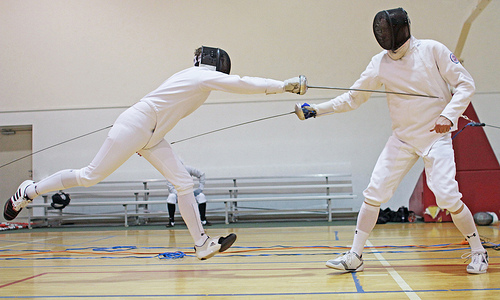

In [60]:
display(Image(os.path.join(path, "flickr30k_images", pos_samples["path"].iloc[0])))

## Negative sample

In [76]:
neg_samples = dataset_final[(dataset_final["path"] == "2178295748.jpg") & (dataset_final["label"] == 0)]
neg_samples

,path,description,description2,label
1,2178295748.jpg,a man with a red shirt is holding a lot of lot...,a blue and black trampoline with two children ...,0
30673,2178295748.jpg,a male wearing a blue coat is cleaning or shar...,an old man wearing glasses and gray suit ridin...,0
109851,2178295748.jpg,the man in the blue shirt is playing fetch wit...,a woman in a yellow shirt with bright orange h...,0
119912,2178295748.jpg,a solitary man balanced on scaffolding high ab...,a busy day for citizens at a local city court .,0
126726,2178295748.jpg,a man in sunglasses is holding a child at the ...,two men play electric guitars .,0


In [77]:
neg_samples["description"].tolist()

['a man with a red shirt is holding a lot of lottery tickets .',
 'a male wearing a blue coat is cleaning or sharpening a chainsaw blade .',
 'the man in the blue shirt is playing fetch with his two dogs .',
 'a solitary man balanced on scaffolding high above the city .',
 'a man in sunglasses is holding a child at the top of a slide']

In [81]:
neg_samples["description2"].tolist()

['a blue and black trampoline with two children sitting on it , one smiling , is in front of a couple kissing and a large white and orange tent with numerous tables and people .',
 'an old man wearing glasses and gray suit riding a bicycle next to a bus with a picture of the movie iron man .',
 'a woman in a yellow shirt with bright orange hair dispenses from a beer tap .',
 'a busy day for citizens at a local city court .',
 'two men play electric guitars .']

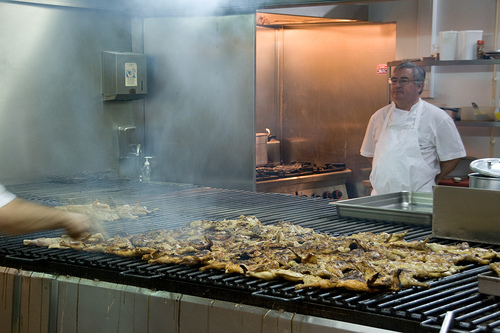

In [78]:
display(Image(os.path.join(path, "flickr30k_images", neg_samples["path"].iloc[0])))